# Bias
Hand crafted feature based on the frequency of biased words.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import pickle

from hyper.bias_scorer import BiasScorer
import hyper.eval as evl

from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv("../data/processed.csv", sep="\t", dtype={"content": "string", "label": bool})

In [3]:
X = data["content"]
y = data["label"].astype(int)

In [4]:
word_list = pd.read_csv("../data/bias/bias-lexicon.txt", header=None, names=["word"])

In [5]:
bs = BiasScorer(word_list["word"])

In [6]:
scores = [bs.score(sentence) for sentence in X]

In [7]:
# add the scores to the dataset
data["lemma_score"] = [x for (x, _) in scores]
data["stem_score"] = [y for (_, y) in scores]

In [8]:
model = LogisticRegression(max_iter=300, class_weight="balanced")

In [9]:
evl.report_algorithm(data[["lemma_score"]], y, model)

{'acc': [0.5689922480620155, 0.010515240283915163],
 'prec': [0.43706030915121563, 0.009995210608984523],
 'rec': [0.5803191489361702, 0.0631236800969688],
 'f1': [0.49694192947740995, 0.023874313217302278]}

In [10]:
evl.report_algorithm(data[["stem_score"]], y, model)

{'acc': [0.5348837209302326, 0.03139295617258384],
 'prec': [0.3995799582104932, 0.02605229525805938],
 'rec': [0.513209219858156, 0.07300810462461155],
 'f1': [0.44712685387054385, 0.036480638577498684]}

In [11]:
evl.report_algorithm(data[["stem_score", "lemma_score"]], y, model)

{'acc': [0.5565891472868217, 0.017947033957814298],
 'prec': [0.4226155564865242, 0.019612927732921018],
 'rec': [0.5549645390070921, 0.07893755614237048],
 'f1': [0.4777414465677158, 0.03912489859739928]}

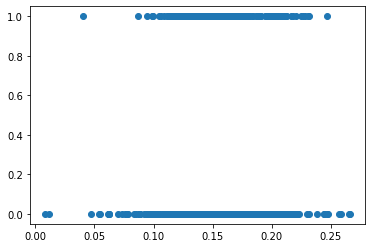

In [12]:
plt.scatter(data["stem_score"], data["label"])

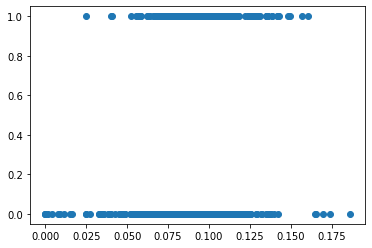

In [13]:
plt.scatter(data["lemma_score"], data["label"])

## Combining with semantic features

In [14]:
with open("../data/transformed/spacy_flair.pickle", "rb") as file:
    X_transformed = pickle.load(file)

In [15]:
big_data = pd.concat([data, pd.DataFrame(X_transformed)], axis=1)

In [16]:
big_X = big_data.drop(["label", "content"], axis=1)

In [17]:
evl.report_algorithm(big_X, y, model)

{'acc': [0.8031007751937983, 0.03753090988189211],
 'prec': [0.7204008398488527, 0.054281538261511136],
 'rec': [0.7693262411347519, 0.059111066035563674],
 'f1': [0.7426885640272767, 0.04677458063181635]}

In [18]:
evl.report_algorithm(X_transformed, y, model)

{'acc': [0.8031007751937983, 0.03753090988189211],
 'prec': [0.7204008398488527, 0.054281538261511136],
 'rec': [0.7693262411347519, 0.059111066035563674],
 'f1': [0.7426885640272767, 0.04677458063181635]}

So the new values have next to no impact.

My concern here is that I'm trying to combine 1000 dimensional vector embeddings with scalars. The 1000 dimension embeddings "overpower" the scalars, maybe this isn't an issue though, if the scalars were actually having an input they would affect it.

Try and experiment by putting y into instead of the scalars. 

In [19]:
# Create a fake dataset, where the true labels are included 
# along with the 1000 dimensional embeddings
X_fake = pd.concat([pd.Series(y), pd.DataFrame(X_transformed)], axis=1)

In [20]:
evl.report_algorithm(X_fake, y, model)

{'acc': [1.0, 0.0], 'prec': [1.0, 0.0], 'rec': [1.0, 0.0], 'f1': [1.0, 0.0]}

So, if the true labels are included, the algorithm knows to ignore all of the other features. This makes me think that I can include my bias score and stuff concatted with the vectors.